<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/ConvTranspose2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 3.2 MB/s 


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arnaud58/landscape-pictures

 98% 608M/620M [00:05<00:00, 172MB/s]
100% 620M/620M [00:05<00:00, 120MB/s]


In [ ]:
!unzip '/content/landscape-pictures.zip' -d '/content/data'

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets
from tqdm.auto import  tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os
from torchvision.utils import make_grid

In [2]:
data_dir = '/content/data/'

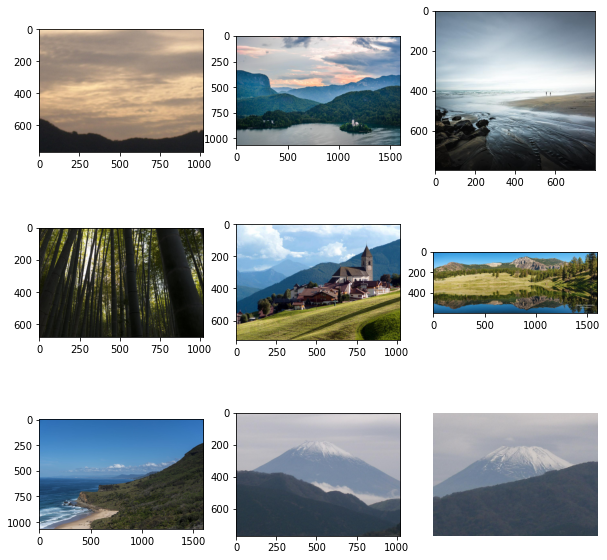

In [3]:
fig = plt.figure(figsize=(10,10))
i = 1
for idx in np.random.randint(0,4319,9):
  ax = fig.add_subplot(3,3,i)
  img = Image.open(data_dir + os.listdir(data_dir)[idx])
  plt.imshow(img)
  i += 1
plt.axis('off')
plt.show()

In [4]:
def show_tensor_images(image_tensor, num_images=7, size=(3, 256, 256)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
train_transforms = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomResizedCrop(256),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),                         
            ])

In [6]:
import glob
train_dir = glob.glob(os.path.join(data_dir + '*.jpg'))

In [7]:
len(train_dir)

4319

In [8]:
class LandScapeDataset(Dataset):
  def __init__(self,input_list,transform = None):
    self.input_list = input_list
    self.transform = transform
  
  def __len__(self):
    return len(self.input_list)
  
  def __getitem__(self,idx):
    img = Image.open(self.input_list[idx]).convert('RGB')
    image_transformed = self.transform(img)
    return image_transformed

In [9]:
dataset = LandScapeDataset(train_dir,train_transforms)

In [10]:
batch_size = 7
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)

In [11]:
device = 'cuda'

In [12]:
class Generator(nn.Module):
    def __init__(self, input_size=200, alpha=0.2):
        super(Generator, self).__init__()       
        kernel_size = 4
        padding = 1
        stride = 2
        
        self.input = nn.Linear(input_size, 4 * 4 * 1024)
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
            nn.Tanh()
        )
  
    def forward(self, z):
        x = self.input(z)
        return self.net(x.view(-1, 1024, 4, 4))

In [13]:
class Discriminator(nn.Module):
    def __init__(self, alpha=0.2):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        if self.training:
            return x
        
        return F.sigmoid(x)

In [14]:
def train_dis(dis, gen, x):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)

    if next(gen.parameters()).is_cuda:
        x = x.cuda()
        z = z.cuda()

    dis.zero_grad()
    y_real_pred = dis(x)
    
    idx = np.random.uniform(0, 1, y_real_pred.shape)
    idx = np.argwhere(idx < 0.03)
    
    # swap some labels and smooth the labels
    ones = np.ones(y_real_pred.shape) + np.random.uniform(-0.1, 0.1)
    ones[idx] = 0
    
    zeros = np.zeros(y_real_pred.shape) + np.random.uniform(0, 0.2)
    zeros[idx] = 1
    ones = torch.from_numpy(ones).float()
    zeros = torch.from_numpy(zeros).float()

    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()
        zeros = zeros.cuda()

    loss_real = F.binary_cross_entropy_with_logits(y_real_pred, ones)

    generated = gen(z)
    y_fake_pred = dis(generated)

    loss_fake = F.binary_cross_entropy_with_logits(y_fake_pred, zeros)
    loss = loss_fake + loss_real
    loss.backward()
    optimizer_dis.step()
    return loss

            
def train_gen(gen, batch_size):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
    
    if next(gen.parameters()).is_cuda:
        z = z.cuda()
    
    gen.zero_grad()
    generated = gen(z)
    y_fake = dis(generated)

    ones = torch.ones_like(y_fake)
    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()

    loss = F.binary_cross_entropy_with_logits(y_fake, ones)
    loss.backward()
    optimizer_gen.step()
    return loss, generated

  0%|          | 0/617 [00:00<?, ?it/s]

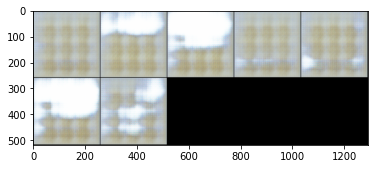

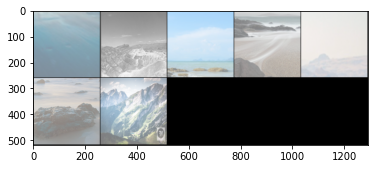

loss: 1.3327628374099731, 	 1.6219052076339722 	 epoch: 0, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

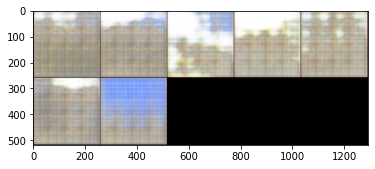

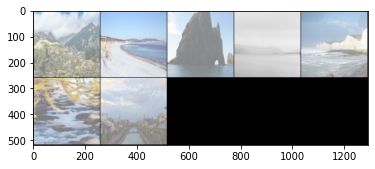

loss: 1.6328543424606323, 	 1.1335482597351074 	 epoch: 1, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

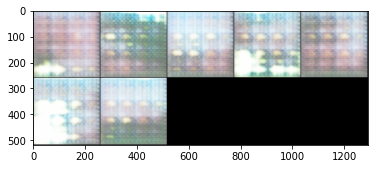

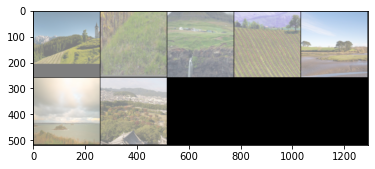

loss: 0.5378708243370056, 	 2.95339035987854 	 epoch: 2, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

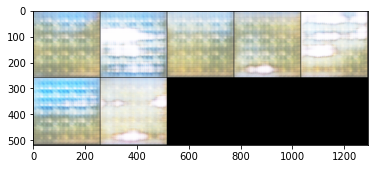

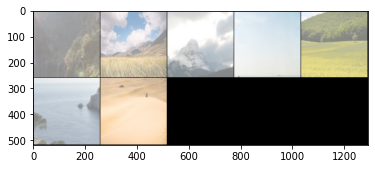

loss: 0.14462465047836304, 	 2.2674312591552734 	 epoch: 3, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

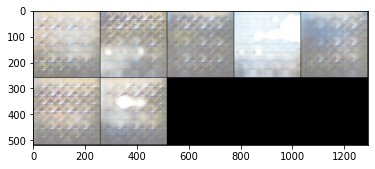

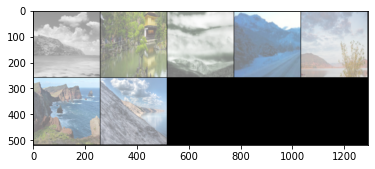

loss: 1.228485107421875, 	 1.7370665073394775 	 epoch: 4, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

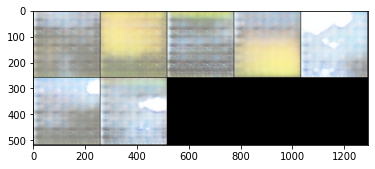

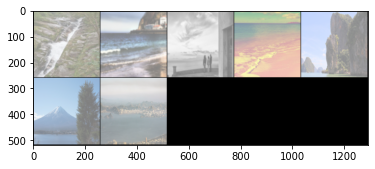

loss: 0.5602013468742371, 	 1.3912383317947388 	 epoch: 5, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

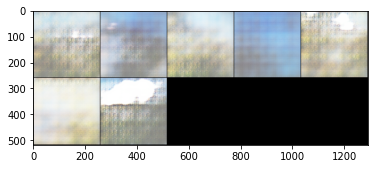

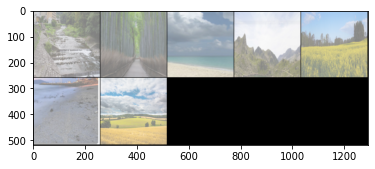

loss: 0.6093785762786865, 	 1.1643521785736084 	 epoch: 6, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

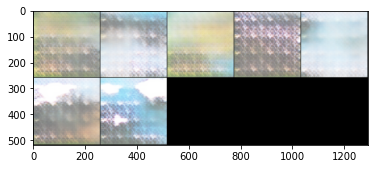

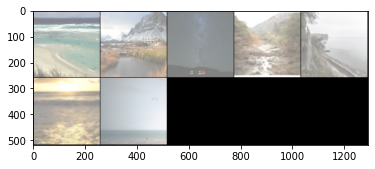

loss: 1.5351890325546265, 	 1.1384543180465698 	 epoch: 7, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

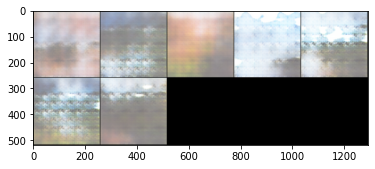

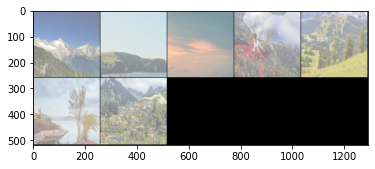

loss: 0.7935689687728882, 	 1.496711254119873 	 epoch: 8, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

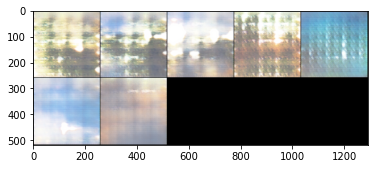

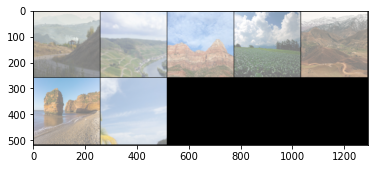

loss: 0.8352234363555908, 	 1.0048998594284058 	 epoch: 9, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

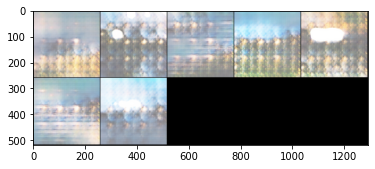

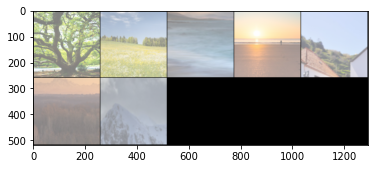

loss: 1.0328562259674072, 	 1.5726618766784668 	 epoch: 10, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

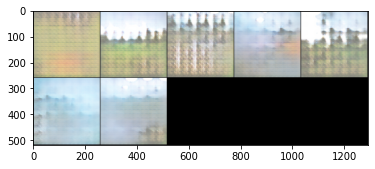

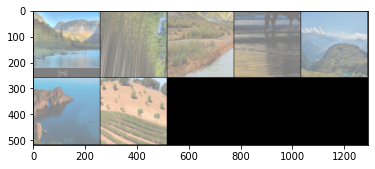

loss: 0.5560877323150635, 	 2.3837833404541016 	 epoch: 11, 	 617/617


  0%|          | 0/617 [00:00<?, ?it/s]

In [ ]:
dis = Discriminator().cuda()
gen = Generator().cuda()

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
optimizer_gen = torch.optim.Adam(gen.parameters(), lr, betas=(beta_1, beta_2))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr, betas=(beta_1, beta_2))

epochs = 20
n = len(train_loader)
for epoch in range(0, epochs):
    c = 0
    n = len(train_loader) 

    for x in tqdm(train_loader): 
        c += 1

        loss_dis = train_dis(dis, gen, x)
        loss_gen, generated = train_gen(gen, batch_size)
        
        global_step = epoch * n + c

        if c % 617 == 0:
          show_tensor_images(generated)
          show_tensor_images(x)
          print(f'loss: {loss_dis.item()}, \t {loss_gen.item()} \t epoch: {epoch}, \t {c}/{n}')


In [ ]:
# gen = Generator().cuda()